In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind
from decimal import Decimal
import math

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

In [3]:
suj = "antisacadas_91"
df = pd.read_csv(f"./raw_data/{suj}.csv")
df.head(5)

rt                                           stimulus  \
0   1006.0  \n    <div style="left: calc(50% - 400px); wid...   
1   7178.0                                                NaN   
2    709.0  \n    <div style="left: calc(50% - 400px); wid...   
3  46036.0                                                NaN   
4   5546.0  \n    <div style="left: calc(50% - 400px); wid...   

                                            response            trial_type  \
0                                                  0  html-button-response   
1  {"anteojos":"no","age":"33","hand":"derecha","...      survey-html-form   
2                                                  0  html-button-response   
3                                                NaN      virtual-chinrest   
4                                                  0  html-button-response   

   trial_index  time_elapsed internal_node_id  run_id  condition  \
0            0          1010          0.0-0.0      91          1   
1            1          8193          0.0-1.0      91          1   
2            2          8904          0.0-2.0      91          1   
3            3         54943          0.0-3.0      91          1   
4            4         60493          0.0-4.0      91          1   

           recorded_at               source_code_version  ip  \
0  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
1  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
2  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
3  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
4  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   

                                          user_agent  device browser  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
1  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
2  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
3  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
4  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   

  browser_version platform  platform_version  item_width_mm  item_height_mm  \
0       107.0.0.0    Linux               NaN            NaN             NaN   
1       107.0.0.0    Linux               NaN            NaN             NaN   
2       107.0.0.0    Linux               NaN            NaN             NaN   
3       107.0.0.0    Linux               NaN           85.6           53.98   
4       107.0.0.0    Linux               NaN            NaN             NaN   

   item_width_px  px2mm  view_dist_mm  item_width_deg  px2deg  win_width_deg  \
0            NaN    NaN           NaN             NaN     NaN            NaN   
1            NaN    NaN           NaN             NaN     NaN            NaN   
2            NaN    NaN           NaN             NaN     NaN            NaN   
3          312.0   3.64        505.91         9.67142   32.26      52.076875   
4            NaN    NaN           NaN             NaN     NaN            NaN   

   win_height_deg success timeout failed_images failed_audio failed_video  \
0             NaN     NaN     NaN           NaN          NaN          NaN   
1             NaN     NaN     NaN           NaN          NaN          NaN   
2             NaN     NaN     NaN           NaN          NaN          NaN   
3       26.720397     NaN     NaN           NaN          NaN          NaN   
4             NaN     NaN     NaN           NaN          NaN          NaN   

  jspsych_start_time  load_time response_type key_press  avg_frame_time  \
0                NaN        NaN           NaN       NaN             NaN   
1                NaN        NaN           NaN       NaN             NaN   
2                NaN        NaN           NaN       NaN             NaN   
3                NaN        NaN           NaN       NaN             NaN   
4                NaN        NaN           NaN       NaN             NaN   

   center_x  center_y rastoc-type stimulus-coordina

In [33]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    interpolate=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc=0.5,
) -> dict:
    """Pre process webcam eye tracking data

    Args:
        df (pd.DataFrame): _description_
        type_of_saccade (str): _description_
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.
        threshold_to_accept_sacc (float, optional): _description_. Defaults to 0.5.

    Returns:
        dict: _description_
    """

    # 0. Estoy sacando los trials de practica (`isTutorial`)
    df_saccade = df.query(
        "not webgazer_data.isnull() and typeOfSaccade == @type_of_saccade and isTutorial == False"
    )

    print("type_of_saccade:", type_of_saccade)
    webgazer_data = df_saccade["webgazer_data"].map(eval)

    ts_xs = []
    baseline_start = -200.0
    baseline_end = 100.0
    pro_sacc_errors = 0
    anti_sacc_errors = 0

    pro_sacc_errors_rt = []
    pro_sacc_correct_rt = []
    anti_sacc_errors_rt = []
    anti_sacc_correct_rt = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # Interpolate
        if interpolate:
            f1 = interp1d(ts, xs, kind="linear")
            ts_new = np.linspace(-200, ts[-1], NEW_SAMPLING_RATE)
            xs = f1(ts_new)
            ts = ts_new

        # 1. Calcular la mediana (o media, podes antibar) entre [-200 0] = Xbase
        x_base = np.mean(xs[(ts > baseline_start) & (ts < baseline_end)])  # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede antibar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts < 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        FILTER = 1.5
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # 6. Savitzky-Golay filter
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira
        xs_after_baseline = xs[ts > baseline_end]
        ts_after_baseline = ts[ts > baseline_end]
        if type_of_saccade == "prosaccade":
            is_sacc_error_in_trial = np.any(
                xs_after_baseline < -threshold_to_accept_sacc
            )
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1
                err_prosacc_idx = np.where(
                    xs_after_baseline < -threshold_to_accept_sacc
                )[0][0]
                err_prosacc_time = ts_after_baseline[err_prosacc_idx]
                pro_sacc_errors_rt.append(f"{err_prosacc_time:.2f}")
            else:
                corr_prosacc_idx = np.where(
                    xs_after_baseline >= threshold_to_accept_sacc
                )[0][0]
                corr_prosacc_time = ts_after_baseline[corr_prosacc_idx]
                pro_sacc_correct_rt.append(f"{corr_prosacc_time:.2f}")

        elif type_of_saccade == "antisaccade":
            is_anti_sacc_error_in_trial = np.any(
                xs_after_baseline > threshold_to_accept_sacc
            )
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1
                err_antisacc_idx = np.where(
                    xs_after_baseline > threshold_to_accept_sacc
                )[0][0]
                err_antisacc_time = ts_after_baseline[err_antisacc_idx]
                anti_sacc_errors_rt.append(f"{err_antisacc_time:.2f}")

            else:
                corr_antisacc_idx = np.where(
                    xs_after_baseline <= -threshold_to_accept_sacc
                )[0][0]
                corr_antisacc_time = ts_after_baseline[corr_antisacc_idx]
                anti_sacc_correct_rt.append(f"{corr_antisacc_time:.2f}")

        ts_xs.append((ts, xs))

    trials_rejected = 100 - (len(ts_xs) / len(webgazer_data) * 100)
    print(f"Trials rejected:{ trials_rejected :.2f} %")
    print("pro_sacc_errors:", pro_sacc_errors)
    print("anti_sacc_errors:", anti_sacc_errors)

    return {
        "ts_xs": ts_xs,
        "pro_sacc_errors": pro_sacc_errors,
        "anti_sacc_errors": anti_sacc_errors,
        "trials_rejected": trials_rejected,
        "pro_sacc_errors_rt": pro_sacc_errors_rt,
        "pro_sacc_correct_rt": pro_sacc_correct_rt,
        "anti_sacc_errors_rt": anti_sacc_errors_rt,
        "anti_sacc_correct_rt": anti_sacc_correct_rt,
    }


def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = (
            (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))
        ) + a
        values_normalized.append(res)
    return np.array(values_normalized)


def one_subject(df, suj_number, type_of_saccade):
    suj_number = str(suj_number)
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        plt.plot(ts, xs)

    plt.title(f"{suj_number} {type_of_saccade}")
    plt.axhline(y=0.5, color="k", linestyle="-")
    plt.axhline(y=-0.5, color="k", linestyle="-")
    plt.ylabel("x coordinate predictions")
    plt.xlabel("time (ms)")
    plt.xticks(np.arange(-200, 1000, step=100))
    # plt.xlim(-200, 1000)
    # plt.ylim(-2, 2)
    plt.show()


In [34]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
anti_saccades_errors = []
trials_rejected_prosaccade = []
trials_rejected_antisaccade = []
pro_sacc_errors_rt = []
pro_sacc_correct_rt = []
anti_sacc_errors_rt = []
anti_sacc_correct_rt = []


print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_saccade_dict = pre_processing(
        df, type_of_saccade="antisaccade", interpolate=True
    )
    pro_saccade_dict = pre_processing(
        df, type_of_saccade="prosaccade", interpolate=True
    )
    subjects.append(suj)
    pro_saccades.append(pro_saccade_dict['ts_xs'])
    anti_saccades.append(anti_saccade_dict['ts_xs'])
    pro_saccades_errors.append(pro_saccade_dict['pro_sacc_errors'])
    anti_saccades_errors.append(anti_saccade_dict['anti_sacc_errors'])
    trials_rejected_prosaccade.append(pro_saccade_dict['trials_rejected'])
    trials_rejected_antisaccade.append(anti_saccade_dict['trials_rejected'])
    pro_sacc_errors_rt.append(pro_saccade_dict['pro_sacc_errors_rt'])
    pro_sacc_correct_rt.append(pro_saccade_dict['pro_sacc_correct_rt'])
    anti_sacc_errors_rt.append(anti_saccade_dict['anti_sacc_errors_rt'])
    anti_sacc_correct_rt.append(anti_saccade_dict['anti_sacc_correct_rt'])
    print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades
df_processed_signal["prosaccade_errors"] = pro_saccades_errors
df_processed_signal["antisaccade_errors"] = anti_saccades_errors
df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(
    pro_saccades_errors
)
df_processed_signal[
    "trials_rejected_antisaccade_percentage"
] = trials_rejected_antisaccade
df_processed_signal[
    "trials_rejected_prosaccade_percentage"
] = trials_rejected_prosaccade
df_processed_signal['pro_sacc_errors_rt'] = pro_sacc_errors_rt
df_processed_signal['pro_sacc_correct_rt'] = pro_sacc_correct_rt
df_processed_signal['anti_sacc_errors_rt'] = anti_sacc_errors_rt
df_processed_signal['anti_sacc_correct_rt'] = anti_sacc_correct_rt

print(" ")
print("✅df_processed_signal ready✅")
df_processed_signal


processing ...
raw_data/antisacadas_111.csv
type_of_saccade: antisaccade
Trials rejected:6.25 %
pro_sacc_errors: 0
anti_sacc_errors: 10
type_of_saccade: prosaccade
Trials rejected:5.62 %
pro_sacc_errors: 12
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_112.csv
type_of_saccade: antisaccade
Trials rejected:1.88 %
pro_sacc_errors: 0
anti_sacc_errors: 4
type_of_saccade: prosaccade
Trials rejected:4.38 %
pro_sacc_errors: 4
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_107.csv
type_of_saccade: antisaccade
Trials rejected:7.50 %
pro_sacc_errors: 0
anti_sacc_errors: 8
type_of_saccade: prosaccade
Trials rejected:6.25 %
pro_sacc_errors: 5
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_109.csv
type_of_saccade: antisaccade
Trials rejected:12.50 %
pro_sacc_errors: 0
anti_sacc_errors: 16
type_of_saccade: prosaccade
Trials rejected:6.25 %
pro_sacc_errors: 6
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_110.csv
type_of_saccade: antisaccade
Trials rejected:16.25 %
pro_sacc_errors: 0
anti_sacc_errors

subject                                         prosaccade  \
0      111  [([-200.0, -164.20689655172413, -128.413793103...   
1      112  [([-200.0, -165.10344827586206, -130.206896551...   
2      107  [([-200.0, -165.24137931034483, -130.482758620...   
3      109  [([-200.0, -164.82758620689657, -129.655172413...   
4      110  [([-200.0, -164.79310344827587, -129.586206896...   
5       98  [([-200.0, -165.48275862068965, -130.965517241...   
6       91  [([-200.0, -165.0344827586207, -130.0689655172...   
7      103  [([-200.0, -164.6551724137931, -129.3103448275...   
8      102  [([-200.0, -165.9310344827586, -131.8620689655...   
9       92  [([-200.0, -164.3793103448276, -128.7586206896...   
10      99  [([-200.0, -164.89655172413794, -129.793103448...   
11     105  [([-200.0, -164.79310344827587, -129.586206896...   
12     101  [([-200.0, -165.31034482758622, -130.620689655...   
13     100  [([-200.0, -165.27586206896552, -130.551724137...   
14     104  [([-200.0, -164.17241379310343, -128.344827586...   

                                          antisaccade  prosaccade_errors  \
0   [([-200.0, -165.17241379310343, -130.344827586...                 12   
1   [([-200.0, -165.6206896551724, -131.2413793103...                  4   
2   [([-200.0, -164.44827586206895, -128.896551724...                  5   
3   [([-200.0, -164.86206896551724, -129.724137931...                  6   
4   [([-200.0, -166.27586206896552, -132.551724137...                  8   
5   [([-200.0, -165.41379310344828, -130.827586206...                  1   
6   [([-200.0, -165.3448275862069, -130.6896551724...                  6   
7   [([-200.0, -165.13793103448276, -130.275862068...                  5   
8   [([-200.0, -165.13793103448276, -130.275862068...                 21   
9   [([-200.0, -165.75862068965517, -131.517241379...                  7   
10  [([-200.0, -165.0689655172414, -130.1379310344...                  3   
11  [([-200.0, -164.27586206896552, -128.551724137...                  2   
12  [([-200.0, -165.3793103448276, -130.7586206896...                  3   
13  [([-200.0, -165.41379310344828, -130.827586206...                  8   
14  [([-200.0, -164.9310344827586, -129.8620689655...                  7   

    antisaccade_errors  delta_errors  trials_rejected_antisaccade_percentage  \
0                   10            -2                                   6.250   
1                    4             0                                   1.875   
2                    8             3                                   7.500   
3                   16            10                                  12.500   
4                    6            -2                                  16.250   
5                    4             3                                   8.750   
6                    4            -2                                  11.875   
7                   14             9                                   3.750   
8                    6           -15                                   3.125   
9                   14             7                                   5.625   
10                  10             7                                  12.500   
11                   4             2                                   1.250   
12                   7             4                                  21.250   
13                   8             0                                  16.875   
14                  12             5                                   1.875   

    trials_rejected_prosaccade_percentage  \
0                                   5.625   
1                                   4.375   
2                                   6.250   
3                                   6.250   
4                                   9.375   
5                                   8.125   
6                                   4.375   
7                                   5.000   
8                                   4.375   
9             

/home/gus/Documents/enviroments/precision/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


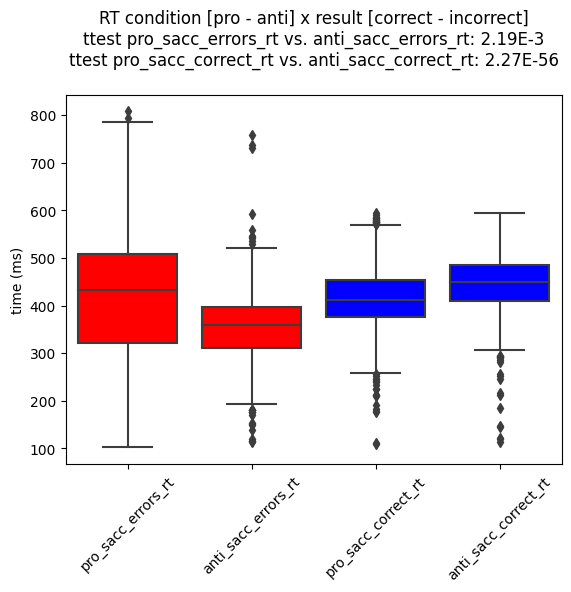

pro_sacc_errors_rt  anti_sacc_errors_rt  pro_sacc_correct_rt  \
count           98.000000           127.000000          2137.000000   
mean           411.834184           352.112835           416.551619   
std            170.847767           117.789508            64.629926   
min            101.970000           113.450000           109.100000   
25%            320.470000           310.515000           375.070000   
50%            432.480000           360.000000           410.760000   
75%            508.107500           396.170000           453.210000   
max            808.000000           758.970000           594.690000   

       anti_sacc_correct_rt  
count            2063.00000  
mean              446.95444  
std                57.72235  
min               114.07000  
25%               410.19000  
50%               449.93000  
75%               486.21000  
max               594.69000

In [38]:
dict_correct_err_rt = {
    "pro_sacc_errors_rt": [
        float(i) for i in df_processed_signal["pro_sacc_errors_rt"].sum()
    ],
    "anti_sacc_errors_rt": [
        float(i) for i in df_processed_signal["anti_sacc_errors_rt"].sum()
    ],
    "pro_sacc_correct_rt": [
        float(i) for i in df_processed_signal["pro_sacc_correct_rt"].sum()
    ],
    "anti_sacc_correct_rt": [
        float(i) for i in df_processed_signal["anti_sacc_correct_rt"].sum()
    ],
}

df_correct_err_rt = pd.DataFrame.from_dict(dict_correct_err_rt, orient="index").T

ax = sns.boxplot(data=df_correct_err_rt)

# Select which box you want to change
boxes = ax.patches

for i, box in enumerate(boxes):
    if "err" in df_correct_err_rt.columns[i]:
        box.set_facecolor("r")
    else:
        box.set_facecolor("b")

plt.setp(ax.get_xticklabels(), rotation=45)
plt.ylabel("time (ms)")
plt.title(
    f"""RT condition [pro - anti] x result [correct - incorrect]
ttest pro_sacc_errors_rt vs. anti_sacc_errors_rt: {Decimal(ttest_ind(dict_correct_err_rt['pro_sacc_errors_rt'], dict_correct_err_rt['anti_sacc_errors_rt'])[1]):.2E}
ttest pro_sacc_correct_rt vs. anti_sacc_correct_rt: {Decimal(ttest_ind(dict_correct_err_rt['pro_sacc_correct_rt'], dict_correct_err_rt['anti_sacc_correct_rt'])[1]):.2E}
"""
)
plt.show()
df_correct_err_rt.describe()


% errors prosacc: 4.38
% correct prosacc: 95.62
% errors antisacc: 5.80
% correct antisacc: 94.20


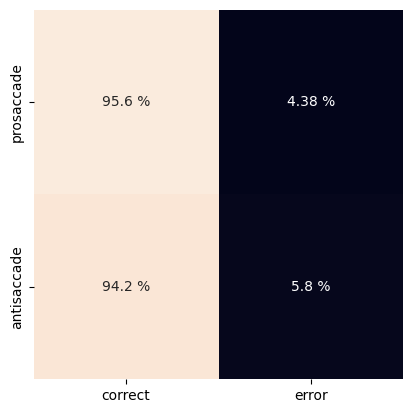

In [36]:
def errors_and_corr_perc(
    pro_sacc_errors_rt, pro_sacc_correct_rt, anti_sacc_errors_rt, anti_sacc_correct_rt
):
    len_prosacc = len(pro_sacc_errors_rt + pro_sacc_correct_rt)
    len_antisacc = len(anti_sacc_errors_rt + anti_sacc_correct_rt)

    print(f"% errors prosacc: {(len(pro_sacc_errors_rt) / len_prosacc) * 100:.2f}")
    print(f"% correct prosacc: {(len(pro_sacc_correct_rt) / len_prosacc) * 100:.2f}")
    print(f"% errors antisacc: {(len(anti_sacc_errors_rt) / len_antisacc) * 100:.2f}")
    print(f"% correct antisacc: {(len(anti_sacc_correct_rt) / len_antisacc) * 100:.2f}")

    return pd.DataFrame(
        {
            "correct": {
                "prosaccade": float(
                    f"{(len(pro_sacc_correct_rt) / len_prosacc) * 100:.2f}"
                ),
                "antisaccade": float(
                    f"{(len(anti_sacc_correct_rt) / len_antisacc) * 100:.2f}"
                ),
            },
            "error": {
                "prosaccade": float(
                    f"{(len(pro_sacc_errors_rt) / len_prosacc) * 100:.2f}"
                ),
                "antisaccade": float(
                    f"{(len(anti_sacc_errors_rt) / len_antisacc) * 100:.2f}"
                ),
            },
        }
    )


df_errors = errors_and_corr_perc(
    dict_correct_err_rt["pro_sacc_errors_rt"],
    dict_correct_err_rt["pro_sacc_correct_rt"],
    dict_correct_err_rt['anti_sacc_errors_rt'],
    dict_correct_err_rt['anti_sacc_correct_rt'],
)

# Plot % of errors and correct responses

# https://stackoverflow.com/a/37603535/13866550
ax = sns.heatmap(df_errors, annot=True, square=True, cbar=False, fmt=".3g")

for t in ax.texts:
    t.set_text(t.get_text() + " %")

plt.show()


In [446]:
for i in ax.texts:
    print(i)

Text(0.5, 0.5, '96.8 %')
Text(1.5, 0.5, '3.15 %')
Text(0.5, 1.5, '94.1 %')
Text(1.5, 1.5, '5.9 %')


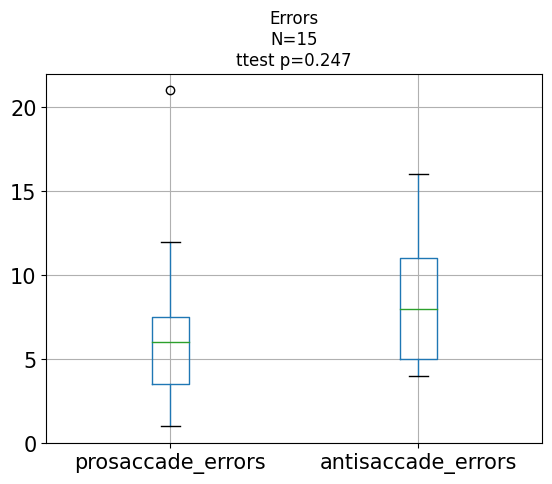

prosaccade_errors  antisaccade_errors
count          15.000000           15.000000
mean            6.533333            8.466667
std             4.867775            4.050867
min             1.000000            4.000000
25%             3.500000            5.000000
50%             6.000000            8.000000
75%             7.500000           11.000000
max            21.000000           16.000000

In [37]:

boxplot = df_processed_signal.boxplot(
    column=["prosaccade_errors", "antisaccade_errors"], fontsize=15, return_type='dict'
)
plt.title(
    f"""Errors
N={len(df_processed_signal)}
ttest p={(ttest_ind(df_processed_signal['prosaccade_errors'], df_processed_signal['antisaccade_errors'])[-1]) :.3f}"""
)
plt.show()

df_processed_signal[["prosaccade_errors", "antisaccade_errors"]].describe()


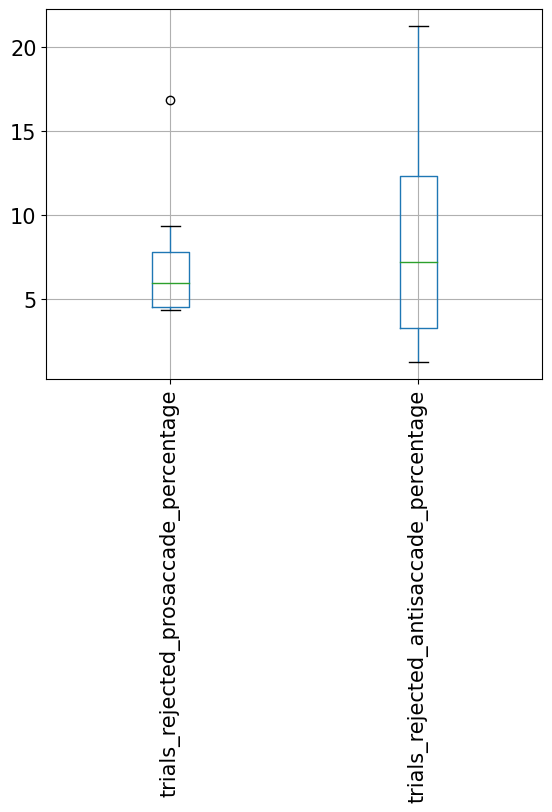

In [244]:
df_processed_signal.boxplot(
    column=[
        "trials_rejected_prosaccade_percentage",
        "trials_rejected_antisaccade_percentage",
    ],
    fontsize=15,
    rot=90,
)
plt.show()


---
111


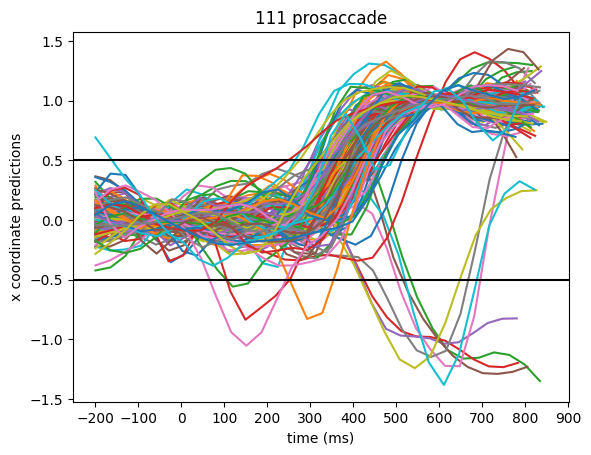

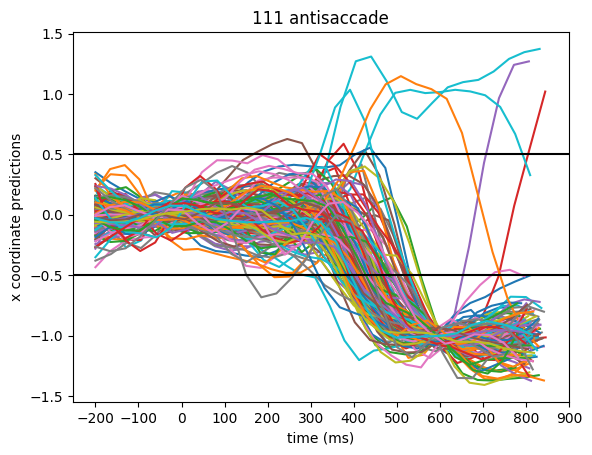

---
112


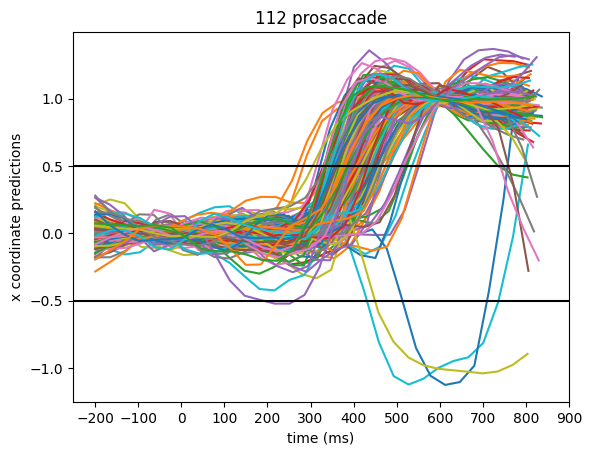

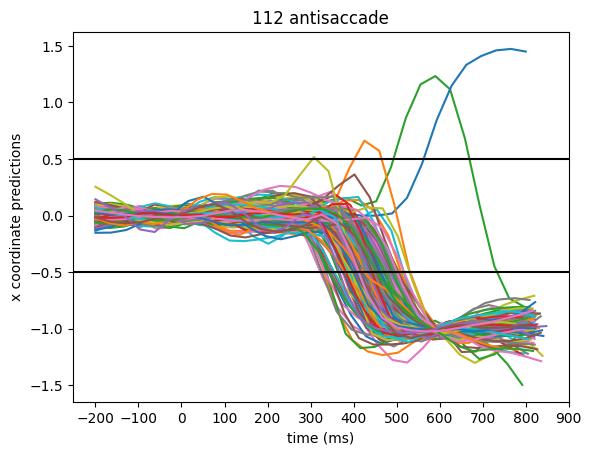

---
107


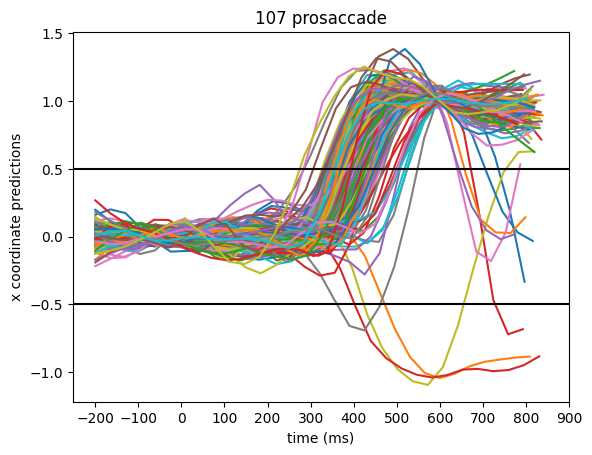

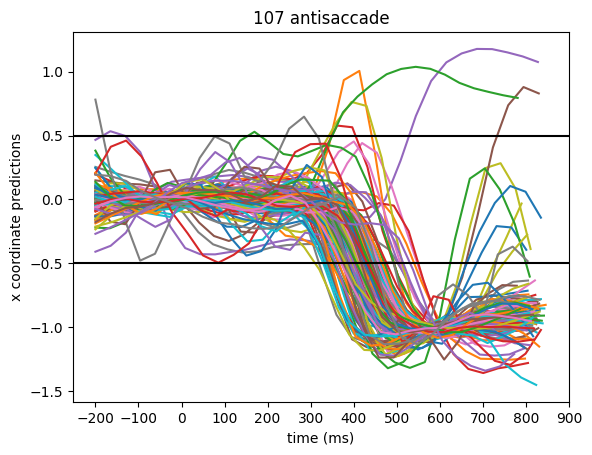

---
109


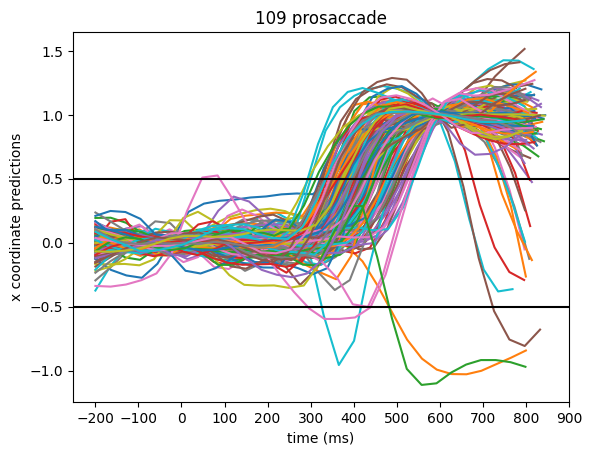

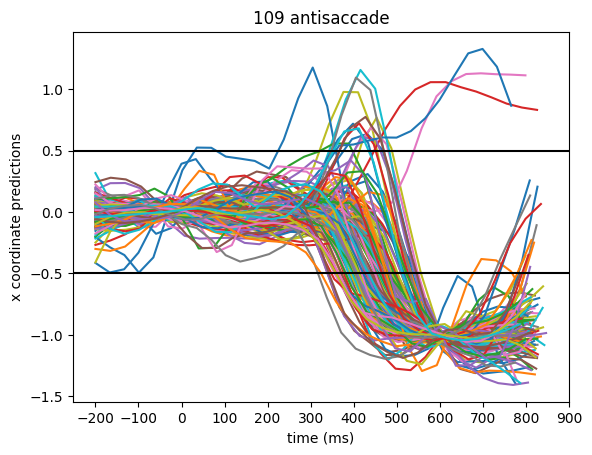

---
110


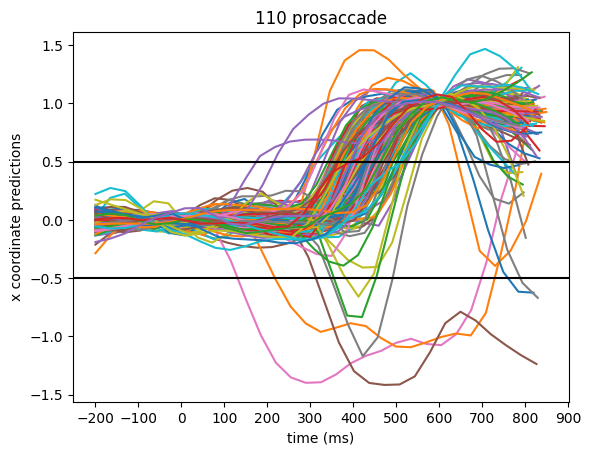

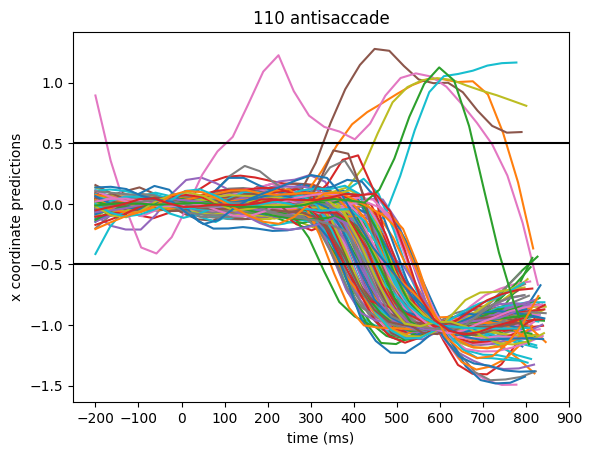

---
98


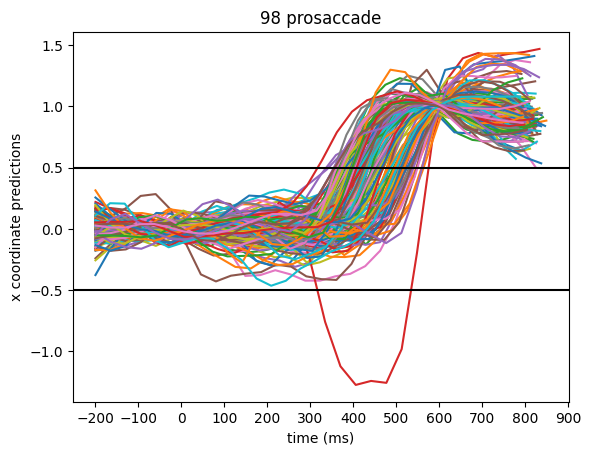

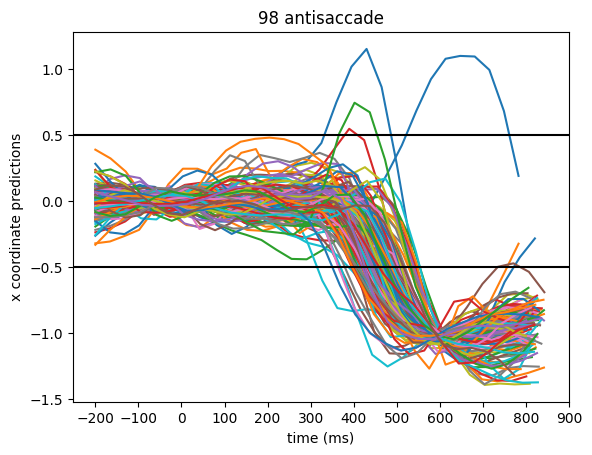

---
91


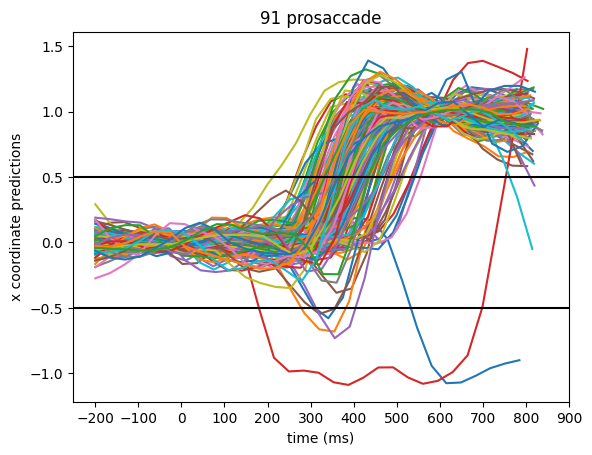

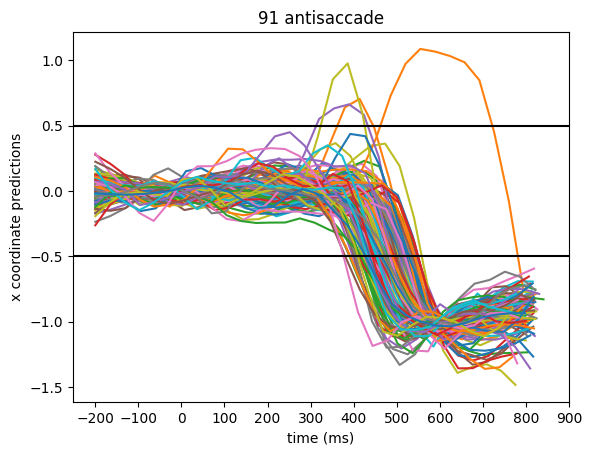

---
103


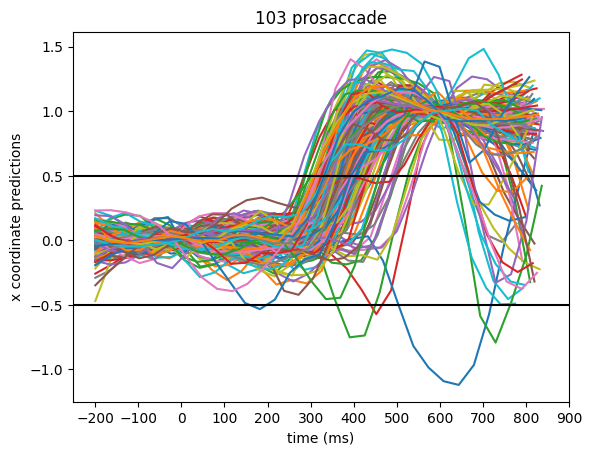

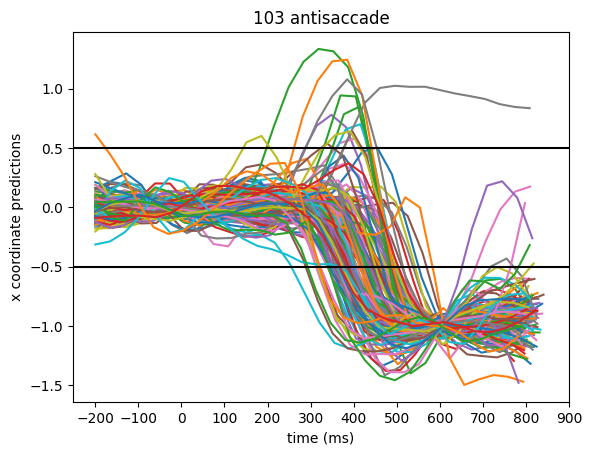

---
102


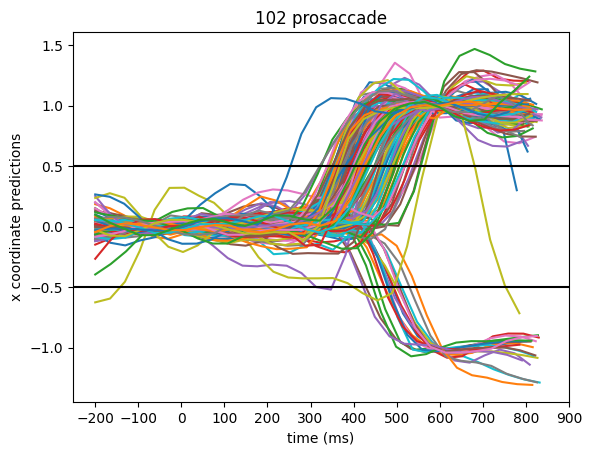

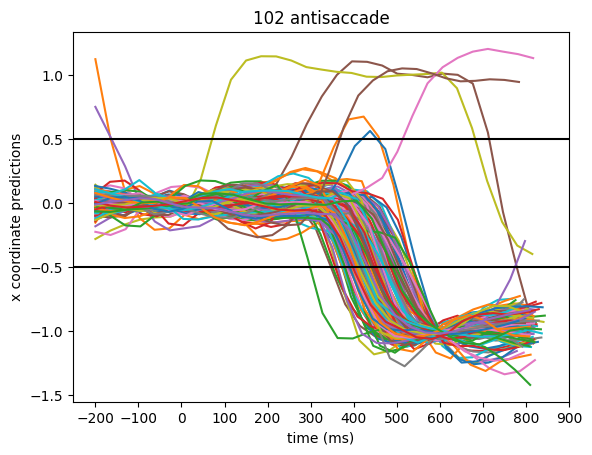

---
92


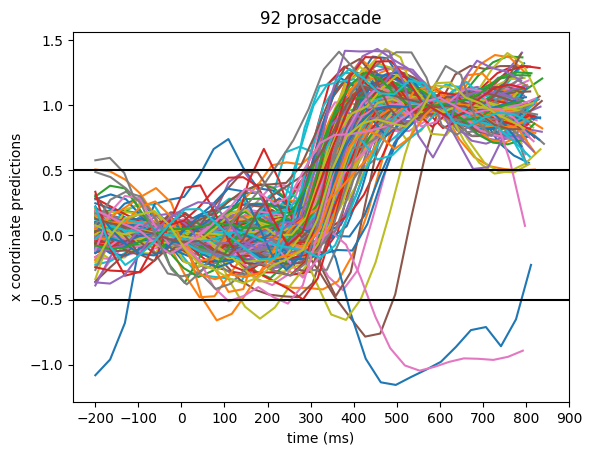

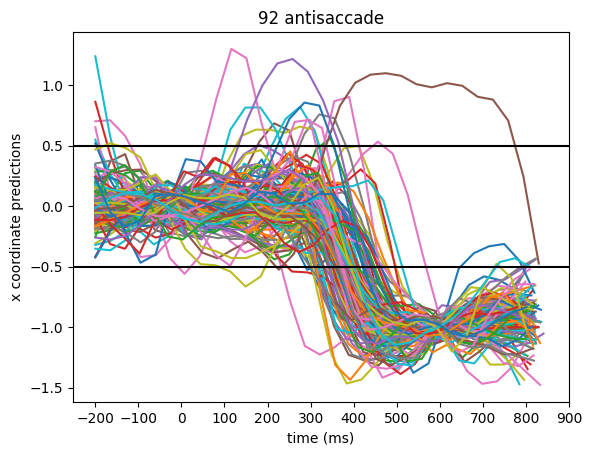

---
99


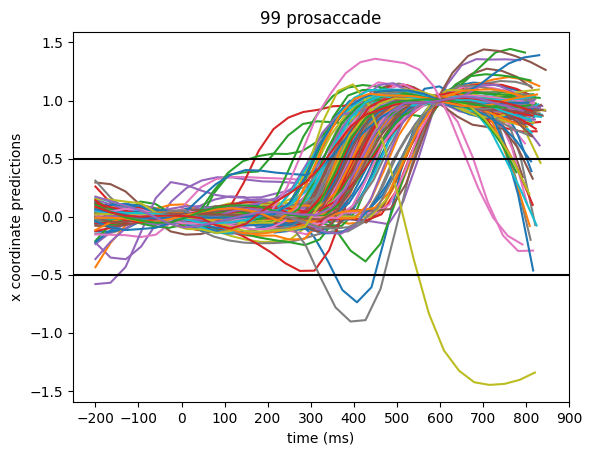

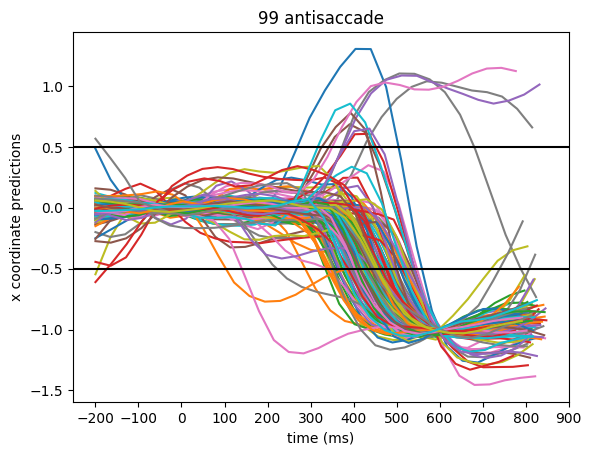

---
105


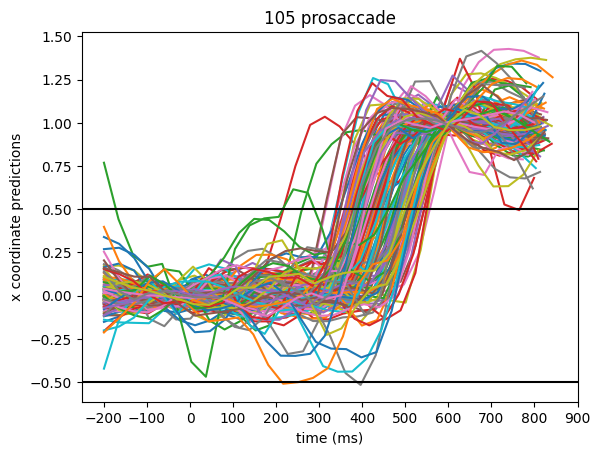

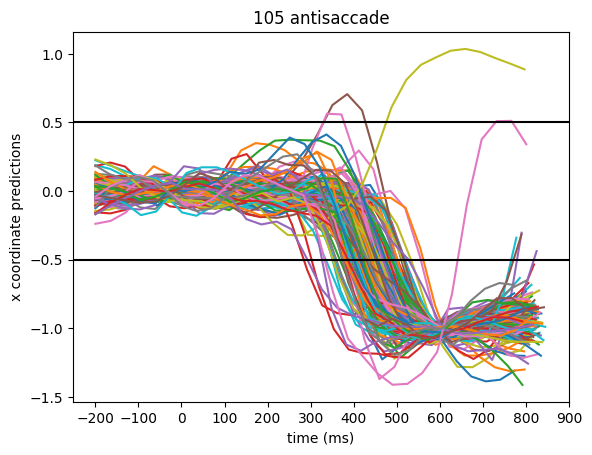

---
101


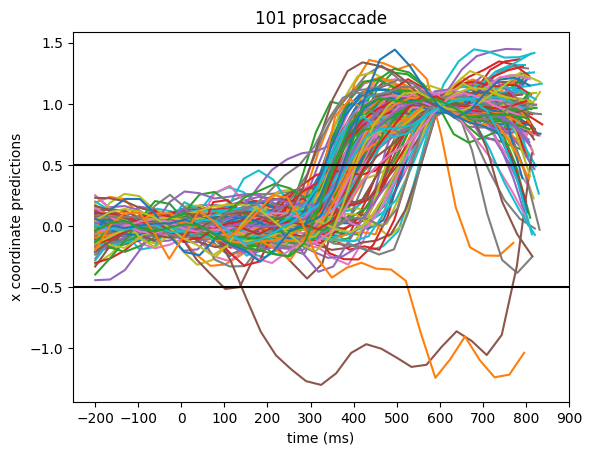

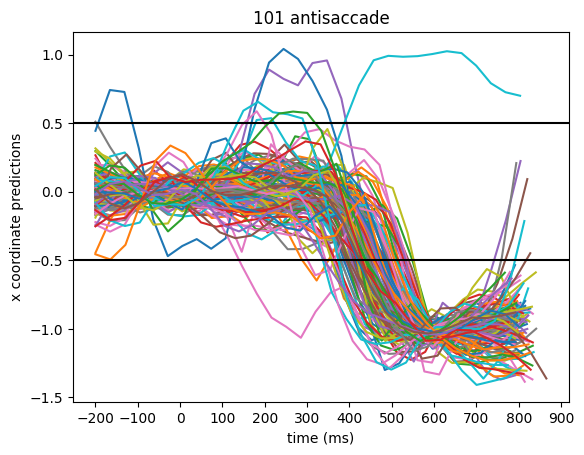

---
100


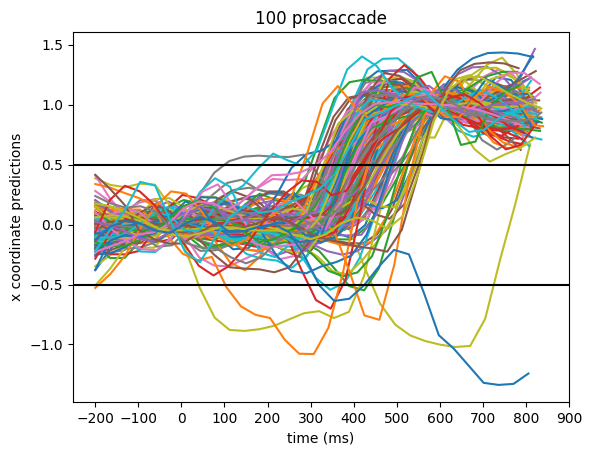

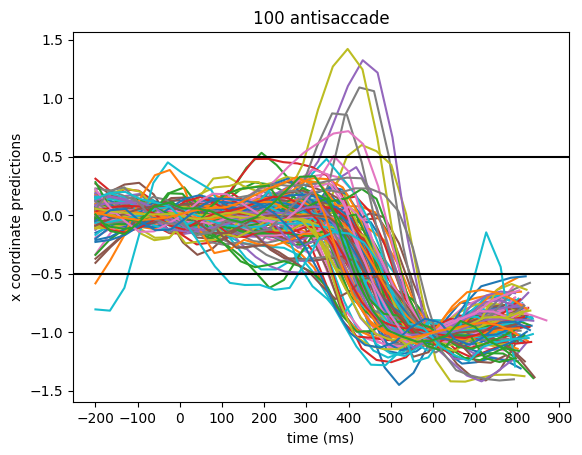

---
104


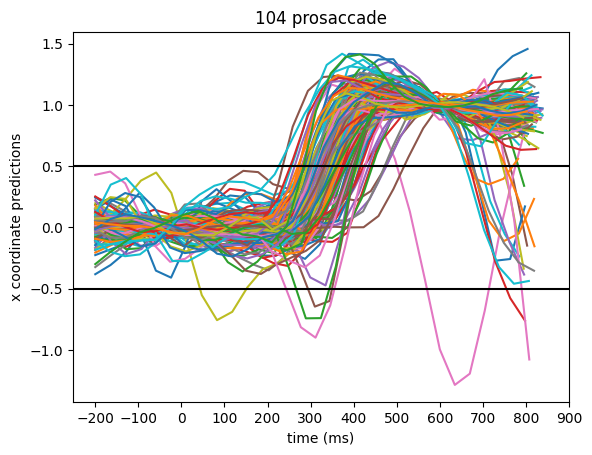

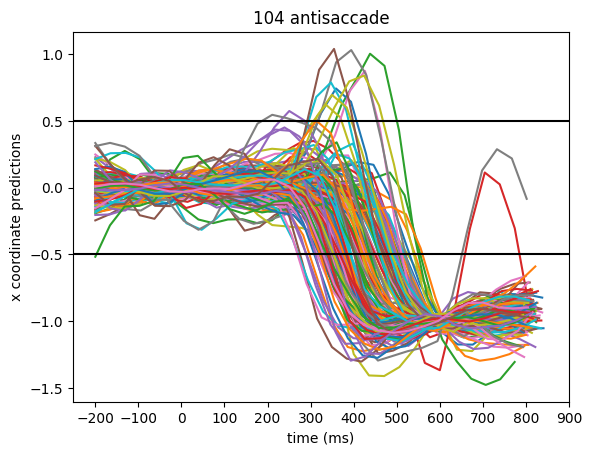

In [39]:
# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split("/")[-1].split(".")[0].split("_")[-1]
    print(suj)
    one_subject(df_processed_signal, suj, "prosaccade")
    one_subject(df_processed_signal, suj, "antisaccade")

### Saccade detection


In [ ]:
# def fixations_saccades_detection(raw, et_channels_meg, subject, sac_max_vel=1500, fix_max_amp=1.5,
#                                  screen_size=38, screen_resolution=1920, force_run=False):

out_fname = f"Fix_Sac_detection_{subject.subject_id}.tsv"
out_folder = paths().preproc_path() + subject.subject_id + "/Sac-Fix_detection/"

meg_gazex_data_clean = et_channels_meg[0]
meg_gazey_data_clean = et_channels_meg[1]
meg_pupils_data_clean = et_channels_meg[2]

if not force_run:
    try:
        # Load pre run saccades and fixation detection
        sac_fix = pd.read_csv(out_folder + out_fname, sep="\t")
        print("\nSaccades and fixations loaded")
    except:
        force_run = True

if force_run:
    # If not pre run data, run
    print("\nRunning saccades and fixations detection")

    # Define data to save to excel file needed to run the saccades detection program Remodnav
    eye_data = {"x": meg_gazex_data_clean, "y": meg_gazey_data_clean}
    df = pd.DataFrame(eye_data)

    # Remodnav parameters
    fname = f"eye_data_{subject.subject_id}.csv"
    px2deg = math.degrees(
        math.atan2(0.5 * screen_size, subject.config.preproc.screen_distance)
    ) / (0.5 * screen_resolution)
    sfreq = raw.info["sfreq"]

    # Save csv file
    df.to_csv(fname, sep="\t", header=False, index=False)

    # Run Remodnav not considering pursuit class and min fixations 100 ms
    command = (
        f"remodnav {fname} {out_fname} {px2deg} {sfreq} --savgol-length {0.0195} --min-pursuit-duration {2} "
        f"--max-pso-duration {0.0} --min-fixation-duration {0.05} --max-vel {5000}"
    )
    os.system(command)

    # Read results file with detections
    sac_fix = pd.read_csv(out_fname, sep="\t")

    # Move eye data, detections file and image to subject results directory
    os.makedirs(out_folder, exist_ok=True)
    # Move et data file
    os.replace(fname, out_folder + fname)
    # Move results file
    os.replace(out_fname, out_folder + out_fname)
    # Move results image
    out_fname = out_fname.replace("tsv", "png")
    os.replace(out_fname, out_folder + out_fname)

# Get saccades and fixations
saccades_all = copy.copy(
    sac_fix.loc[(sac_fix["label"] == "SACC") | (sac_fix["label"] == "ISAC")]
)
fixations_all = copy.copy(sac_fix.loc[sac_fix["label"] == "FIXA"])

# Drop saccades and fixations based on conditions
fixations = copy.copy(fixations_all[(fixations_all["amp"] <= fix_max_amp)])
print(
    f"Dropping saccades with average vel > {sac_max_vel}, and fixations with amplitude > {fix_max_amp}"
)

saccades = copy.copy(saccades_all[saccades_all["peak_vel"] <= sac_max_vel])
print(f"Kept {len(fixations)} out of {len(fixations_all)} fixations")
print(f"Kept {len(saccades)} out of {len(saccades_all)} saccades")

subject.len_all_sac = len(saccades_all)
subject.len_all_fix = len(fixations_all)
subject.len_sac_drop = len(saccades)
subject.len_fix_drop = len(fixations)

times = raw.times
mean_x = []
mean_y = []
pupil_size = []
prev_sac = []
next_sac = []

# Remove fixations from and to blink
print("Finding previous and next saccades")
i = 0
for fix_idx, fixation in fixations.iterrows():
    fix_time = fixation["onset"]
    fix_dur = fixation["duration"]

    sacc_thresh = 0.002  # 2 ms
    # Previous and next saccades
    try:
        sac0 = saccades.loc[
            (saccades["onset"] + saccades["duration"] > fix_time - sacc_thresh)
            & (saccades["onset"] + saccades["duration"] < fix_time + sacc_thresh)
        ].index.values[-1]
    except:
        sac0 = None
    prev_sac.append(sac0)

    try:
        sac1 = saccades.loc[
            (saccades["onset"] > fix_time + fix_dur - sacc_thresh)
            & (saccades["onset"] < fix_time + fix_dur + sacc_thresh)
        ].index.values[0]
    except:
        sac1 = None
    next_sac.append(sac1)

    print("\rProgress: {}%".format(int((i + 1) * 100 / len(fixations))), end="")
    i += 1

# Add columns
fixations["prev_sac"] = prev_sac
fixations["next_sac"] = next_sac

# Drop when None
fixations.dropna(subset=["prev_sac"], inplace=True)
print(f"\nKept {len(fixations)} fixations with previous saccade")

print("Computing average pupil size, and x and y position")
i = 0
for fix_idx, fixation in fixations.iterrows():
    fix_time = fixation["onset"]
    fix_dur = fixation["duration"]

    # Average pupil size, x and y position
    fix_time_idx = np.where(
        np.logical_and(fix_time < times, times < fix_time + fix_dur)
    )[0]

    pupil_data_fix = meg_pupils_data_clean[fix_time_idx]
    gazex_data_fix = meg_gazex_data_clean[fix_time_idx]
    gazey_data_fix = meg_gazey_data_clean[fix_time_idx]

    pupil_size.append(np.nanmean(pupil_data_fix))
    mean_x.append(np.nanmean(gazex_data_fix))
    mean_y.append(np.nanmean(gazey_data_fix))

    print("\rProgress: {}%".format(int((i + 1) * 100 / len(fixations))), end="")
    i += 1

fixations["mean_x"] = mean_x
fixations["mean_y"] = mean_y
fixations["pupil"] = pupil_size
fixations = fixations.astype(
    {
        "mean_x": float,
        "mean_y": float,
        "pupil": float,
        "prev_sac": "Int64",
        "next_sac": "Int64",
    }
)


### Other

In [ ]:
# Podemos poner 0 - 150
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [152]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650


3425